In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp

경로 수정

In [2]:
DATA_DIR = r"C:\Users\swu\Desktop\class_loss_test"
train_dir=os.path.join(DATA_DIR,'train')
test_dir=os.path.join(DATA_DIR,'test')

x_train_dir = os.path.join(DATA_DIR, 'train/image')
y_train_dir = os.path.join(DATA_DIR, 'train/label')

x_valid_dir = os.path.join(DATA_DIR, 'val/image')
y_valid_dir = os.path.join(DATA_DIR, 'val/label')

x_test_dir = os.path.join(DATA_DIR, 'test/image')
y_test_dir = os.path.join(DATA_DIR, 'test/label')

class & RGB 수정

- type1: single_jersey / 청록 (0, 255, 255)
- type2: rib / 빨강 (255, 0, 0)
- type3: purl / 초록 (0, 255, 0)
- type4: interlock 파랑 -> 삭제
- type5: moss / 핑크 (255, 20, 147)
- type6: ajour / 노랑 (255, 255,0)
- background / 검정 (0,0,0)

In [3]:
select_classes = ['type1', 'type2', 'type3', 'type5', 'type6', 'background'] # single, rib, purl
select_class_rgb_values =  [[0,255,255], [255,0,0], [0,255,0], [255,20,147], [255,255,0], [0,0,0]]

def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20,8))

    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        if name=="ground_truth_mask":
          plt.imshow(image, cmap='tab10')
        else:
          plt.imshow(image)
    plt.show()


def one_hot_encode(label, label_values):
    label=label.astype(int)
    semantic_map = []

    for colour in label_values[:-1]:
      distance = np.linalg.norm(label - colour, axis=-1)
      class_map = distance <= 30 
      semantic_map.append(class_map)


    labeled_area = np.any(semantic_map, axis=0)
    unlabeled_area = ~labeled_area

    semantic_map.append(unlabeled_area)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

def reverse_one_hot(image):
    y=[]
    for i in range(len(image)):
      x=np.argmax(image[i], axis =1)
      y.append(x)
    return y

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image]

    return x

class BuildingsDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            images_dir,
            masks_dir,
            class_rgb_values=None,
            augmentation=None,
            augmentation_img=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, mask_id) for mask_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.augmentation_img = augmentation_img
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        if self.augmentation:
            sample1 = self.augmentation(image=image, mask=mask)
            image, mask = sample1['image'], sample1['mask']
            if self.augmentation_img:
                sample2 = self.augmentation_img(image=image, mask=mask)
                image = sample2['image']
        elif self.augmentation_img:
            sample2 = self.augmentation_img(image=image, mask=mask)
            image = sample2['image']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.image_paths)
    
def get_training_augmentation():
    train_transform = [
        album.Resize(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)

def get_training_color_augmentation():
    train_transform2 = [
        album.OneOf(
            [
                album.CLAHE(clip_limit=(1, 5))
                ],
            p=1,
        ),
    ]
    return album.Compose(train_transform2)

def get_validation_augmentation():
    test_transform = [
        album.Resize(height=256, width=256, always_apply=True),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)


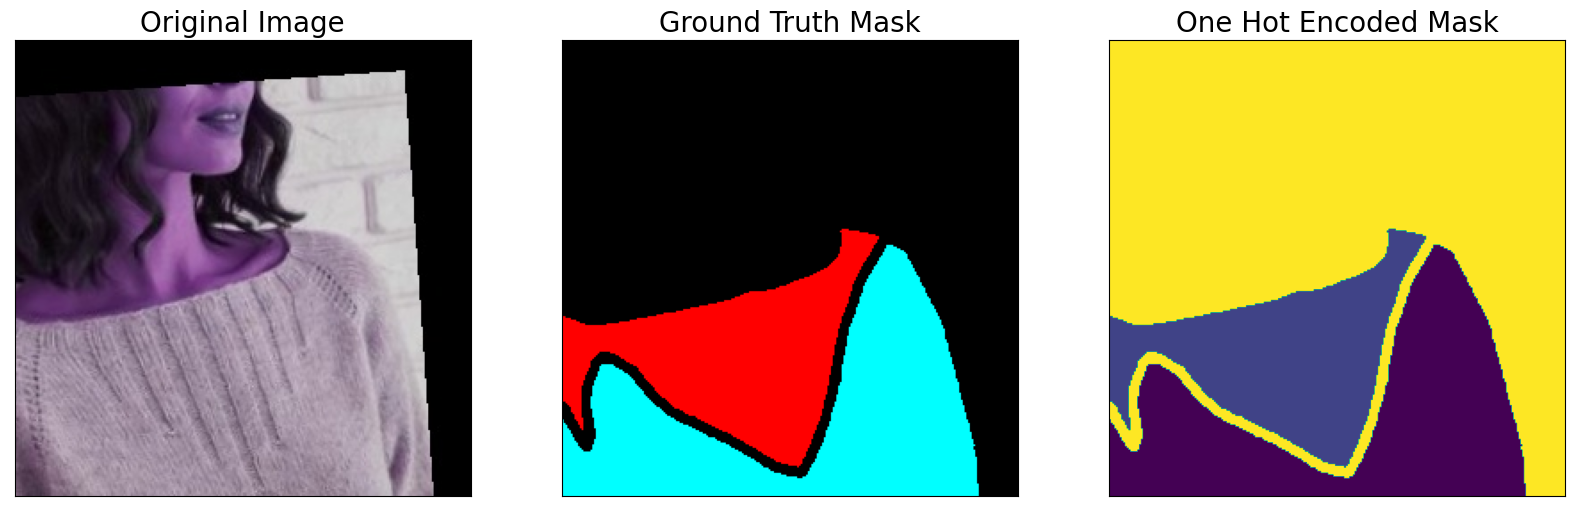

256


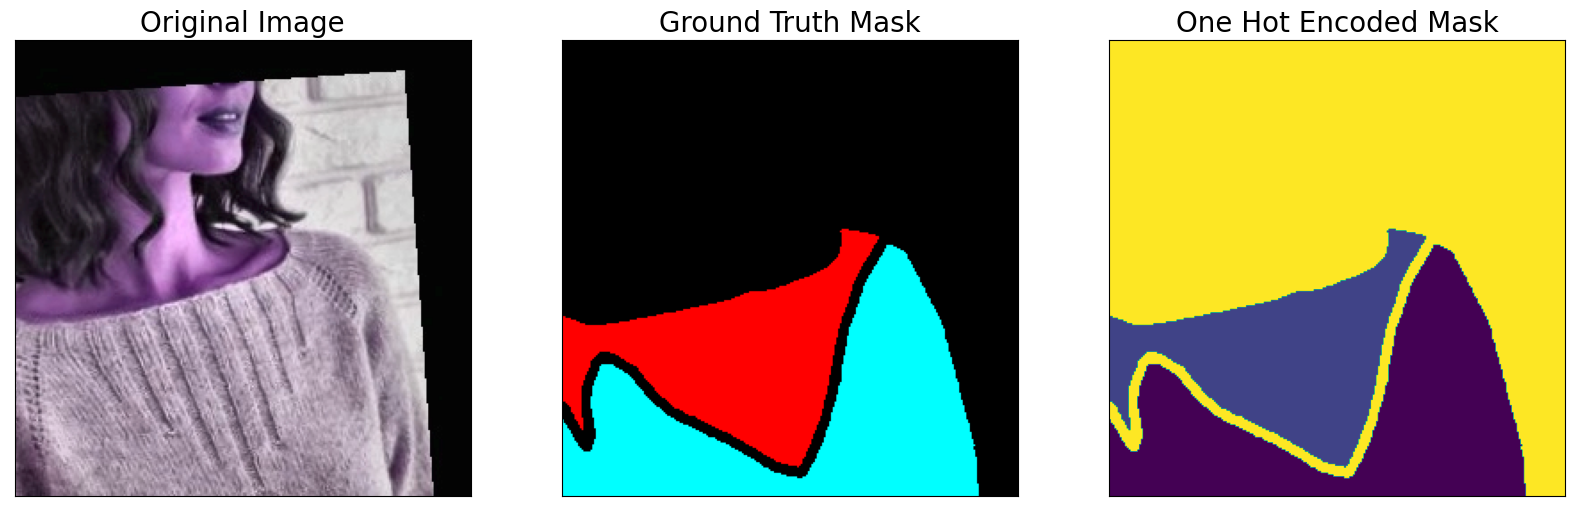

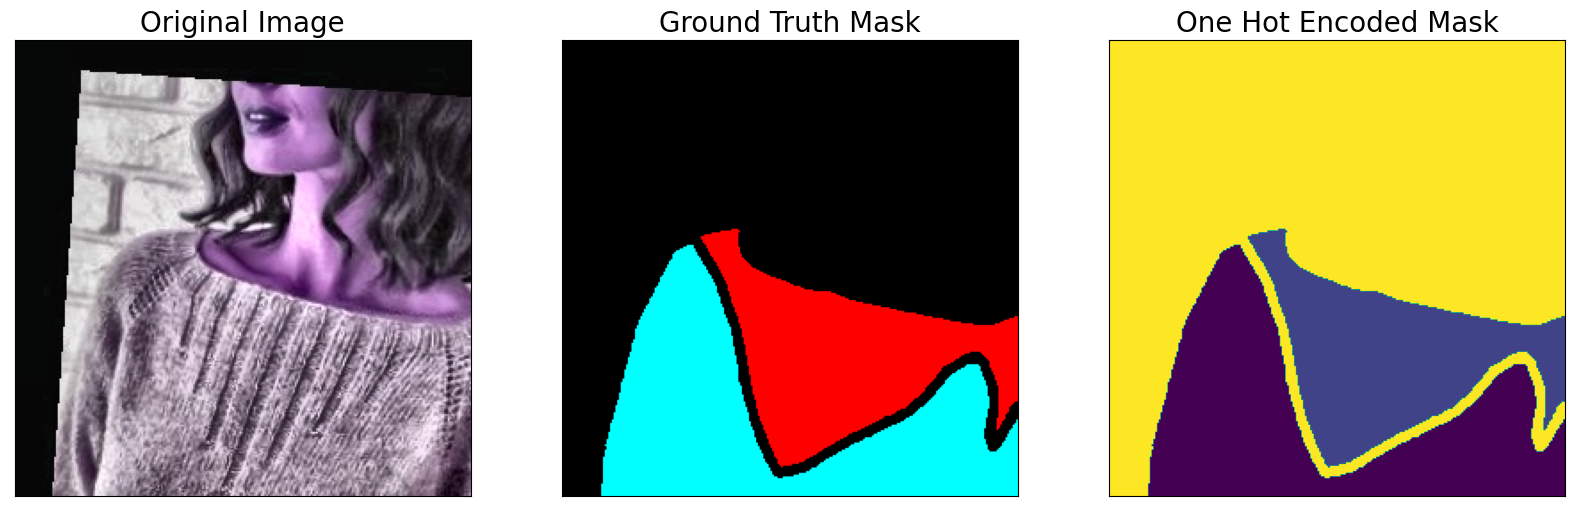

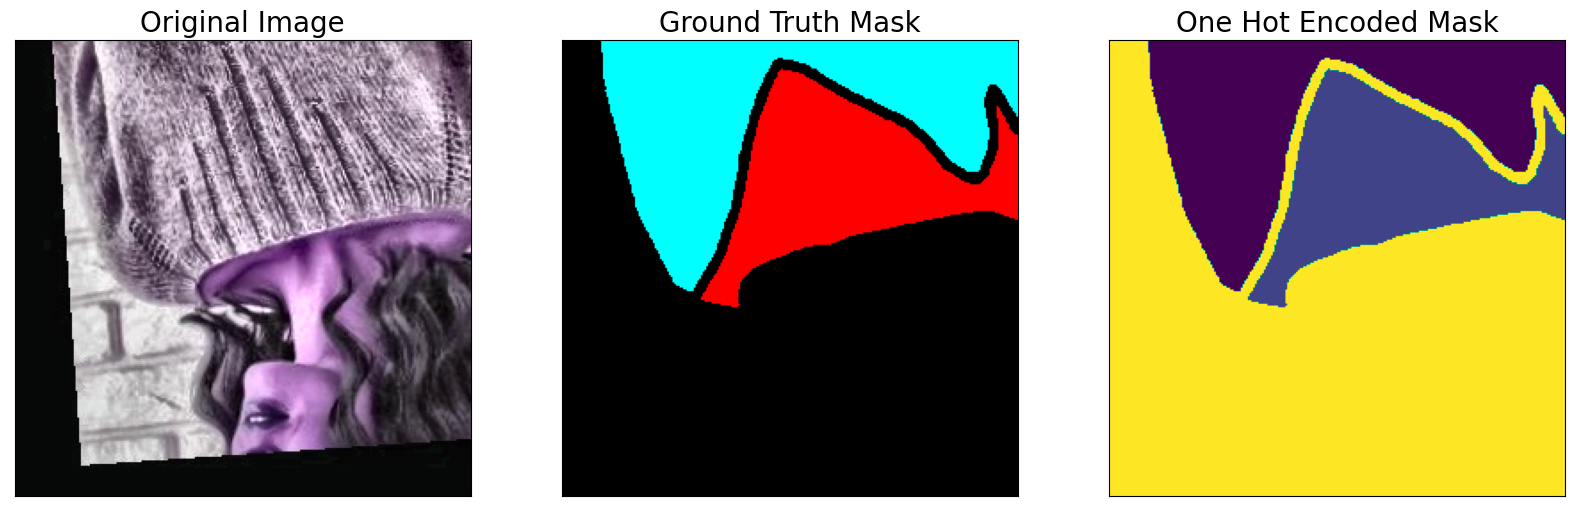

In [4]:
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[1]
ground_truth_mask=[]
for i in range(len(image)):
  ground_truth_mask.append(colour_code_segmentation(reverse_one_hot(mask)[i], select_class_rgb_values))
visualize(
  original_image = image,
  ground_truth_mask=ground_truth_mask,
  one_hot_encoded_mask = reverse_one_hot(mask)
)
print(len(ground_truth_mask))

augmented_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(), ###
    augmentation_img=get_training_color_augmentation(),
    class_rgb_values=select_class_rgb_values
)

random_idx = random.randint(0, len(augmented_dataset)-1)

for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [5]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        # Check if validation loss is nan
        if np.isnan(val_loss):
            self.trace_func("Validation loss is NaN. Ignoring this epoch.")
            return

        if self.best_val_loss is None:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_val_loss - self.delta:
            # Significant improvement detected
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0  # Reset counter since improvement occurred
        else:
            # No significant improvement
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

CLASSES 수정

- type1: single_jersey
- type2: rib
- type3: purl
- type4: interlock
- type5: moss 
- type6: ajour 
- background

In [6]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['type1','type2','type3','type5','type6','background']
ACTIVATION = 'softmax2d'

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    augmentation_img=get_training_color_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)
valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

if __name__ == "__main__":
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
    valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=0)



에포크 설정

In [7]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1e-6):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        y_true = y_true.float()
        tp = torch.sum(y_true * y_pred)
        fp = torch.sum((1 - y_true) * y_pred)
        fn = torch.sum(y_true * (1 - y_pred))
        tversky_index = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        return 1 - tversky_index
    
from segmentation_models_pytorch import utils
import tensorflow as tf

TRAINING = True
EPOCHS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss=smp.losses.FocalLoss(mode='binary')
loss.__name__='focal_loss'

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5)
]
test_metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5)
]
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001, weight_decay=2e-5),
])

lr_scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=10, T_mult=1, eta_max=0.01,  T_up=2, gamma=0.2)
early_stopping = EarlyStopping(patience=7, verbose=True)

In [8]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [9]:
%%time

classwise_epoch_loss = {class_name: [] for class_name in CLASSES}

if TRAINING:
    model.train()
    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for epoch in range(EPOCHS):
        print(f"\nEpoch: {epoch}")

        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)

        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')

        epoch_class_losses = {class_name: [] for class_name in CLASSES}

        for idx in range(len(valid_loader.dataset)):
            image, gt_mask = valid_loader.dataset[idx]
            x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

            with torch.no_grad():
                pred_mask = model(x_tensor)
                pred_mask = pred_mask.detach().squeeze().cpu().numpy()

            pred_mask = np.transpose(pred_mask, (1, 2, 0))
            gt_mask = np.transpose(gt_mask, (1, 2, 0))

            for class_idx, class_name in enumerate(CLASSES):
                pred_class = pred_mask[:, :, class_idx]
                gt_class = gt_mask[:, :, class_idx]

                pred_class_tensor = torch.from_numpy(pred_class).float().to(DEVICE).view(-1)
                gt_class_tensor = torch.from_numpy(gt_class).float().to(DEVICE).view(-1)

                if pred_class_tensor.shape == gt_class_tensor.shape:
                    loss_value = loss(pred_class_tensor, gt_class_tensor).item()
                    epoch_class_losses[class_name].append(loss_value)

        for class_name in CLASSES:
            avg_loss = (sum(epoch_class_losses[class_name]) / len(epoch_class_losses[class_name])) if epoch_class_losses[class_name] else 0.0
            classwise_epoch_loss[class_name].append(avg_loss)

        # Early stopping
        if epoch > 20:
            focal_loss = valid_logs['focal_loss']
            early_stopping(focal_loss, model)
            if early_stopping.early_stop:
                print(f"Epoch {epoch}: Early stopping triggered")
                break


Epoch: 0
valid: 100%|██████████| 31/31 [00:02<00:00, 11.41it/s, focal_loss - 0.1912, iou_score - 0.4146, accuracy - 0.8914, fscore - 0.5642, precision - 0.8449, recall - 0.4347]
Model saved!

Epoch: 1
valid: 100%|██████████| 31/31 [00:02<00:00, 11.62it/s, focal_loss - 0.1744, iou_score - 0.6762, accuracy - 0.9331, fscore - 0.7838, precision - 0.8447, recall - 0.7405]
Model saved!

Epoch: 2
valid: 100%|██████████| 31/31 [00:02<00:00, 11.21it/s, focal_loss - 0.1717, iou_score - 0.678, accuracy - 0.9315, fscore - 0.786, precision - 0.8115, recall - 0.7642]  
Model saved!
Wall time: 1min 26s


In [10]:
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')
    torch.save(best_model,"./DeepLabV3_best_model.pth")

test_dataset = BuildingsDataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

test_dataset_vis = BuildingsDataset(
    x_test_dir, y_test_dir,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

def crop_image(image, target_image_dims=[256,256,3]):

    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

Loaded DeepLabV3+ model from this run.


pred_building_heatmap type 수정

In [ ]:
import sys
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = np.transpose(image, (1, 2, 0))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    pred_mask = np.transpose(pred_mask,(1,2,0))

    pred_building_heatmap = pred_mask[:,:,select_classes.index('type2')]
    pred_mask = (colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))

    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = (colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))

    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_building_heatmap = pred_building_heatmap
    )

In [12]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=test_metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['focal_loss']:.4f}")

print(valid_logs)

valid: 100%|██████████| 123/123 [00:04<00:00, 27.36it/s, focal_loss - 0.1728, iou_score - 0.6587, accuracy - 0.9275, fscore - 0.7758, precision - 0.7948, recall - 0.758] 
Evaluation on Test Data: 
Mean IoU Score: 0.6587
Mean Dice Loss: 0.1728
{'focal_loss': 0.1727957570455907, 'iou_score': 0.6586959154867544, 'accuracy': 0.9275308193230049, 'fscore': 0.7757620729081997, 'precision': 0.7948074423200723, 'recall': 0.7580319536410693}


In [13]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
valid_logs_df.T

,0,1,2
focal_loss,0.191238,0.174362,0.171703
iou_score,0.414576,0.676231,0.678050
accuracy,0.891427,0.933100,0.931483
fscore,0.564216,0.783830,0.786041
precision,0.844923,0.844674,0.811491
recall,0.434735,0.740518,0.764248


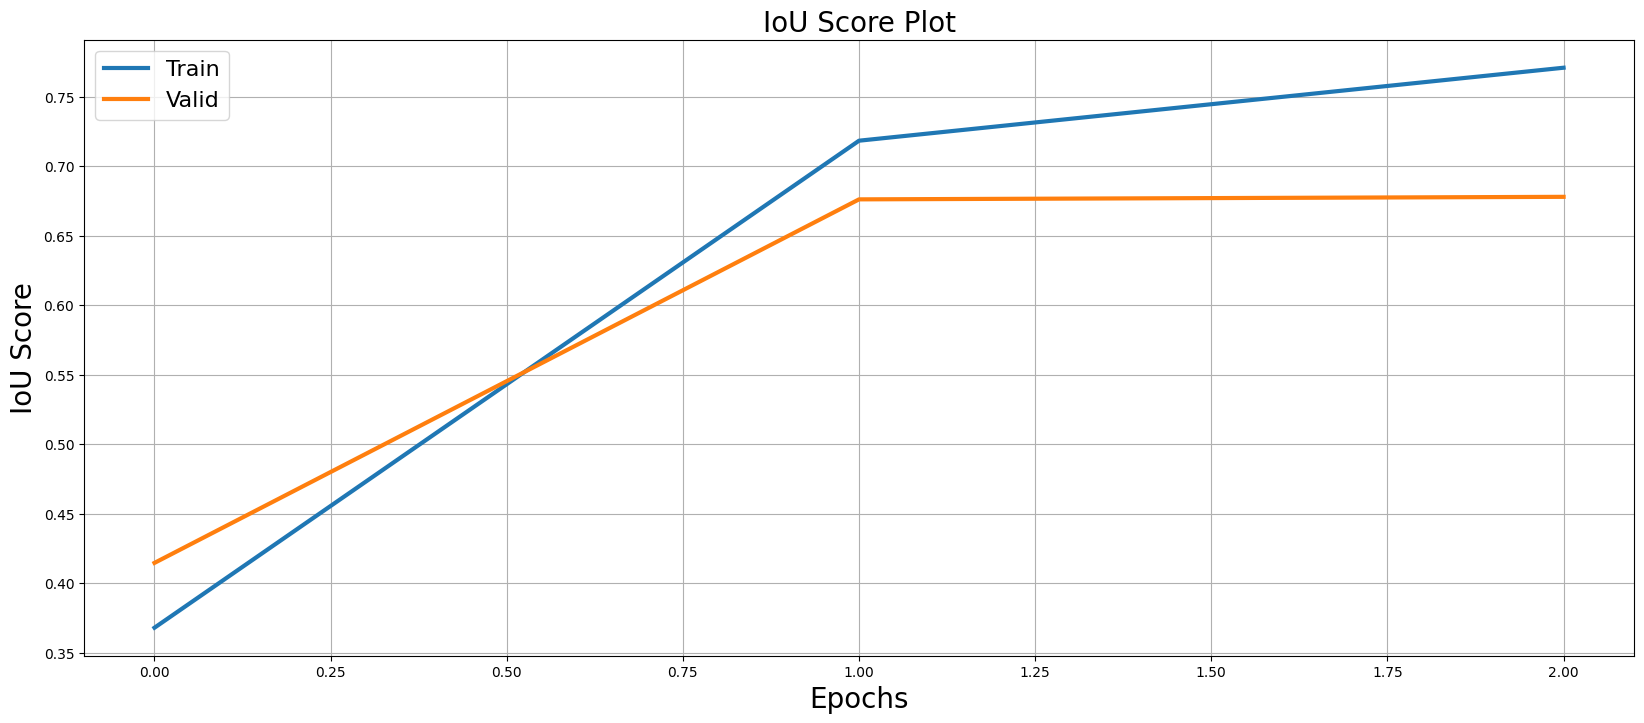

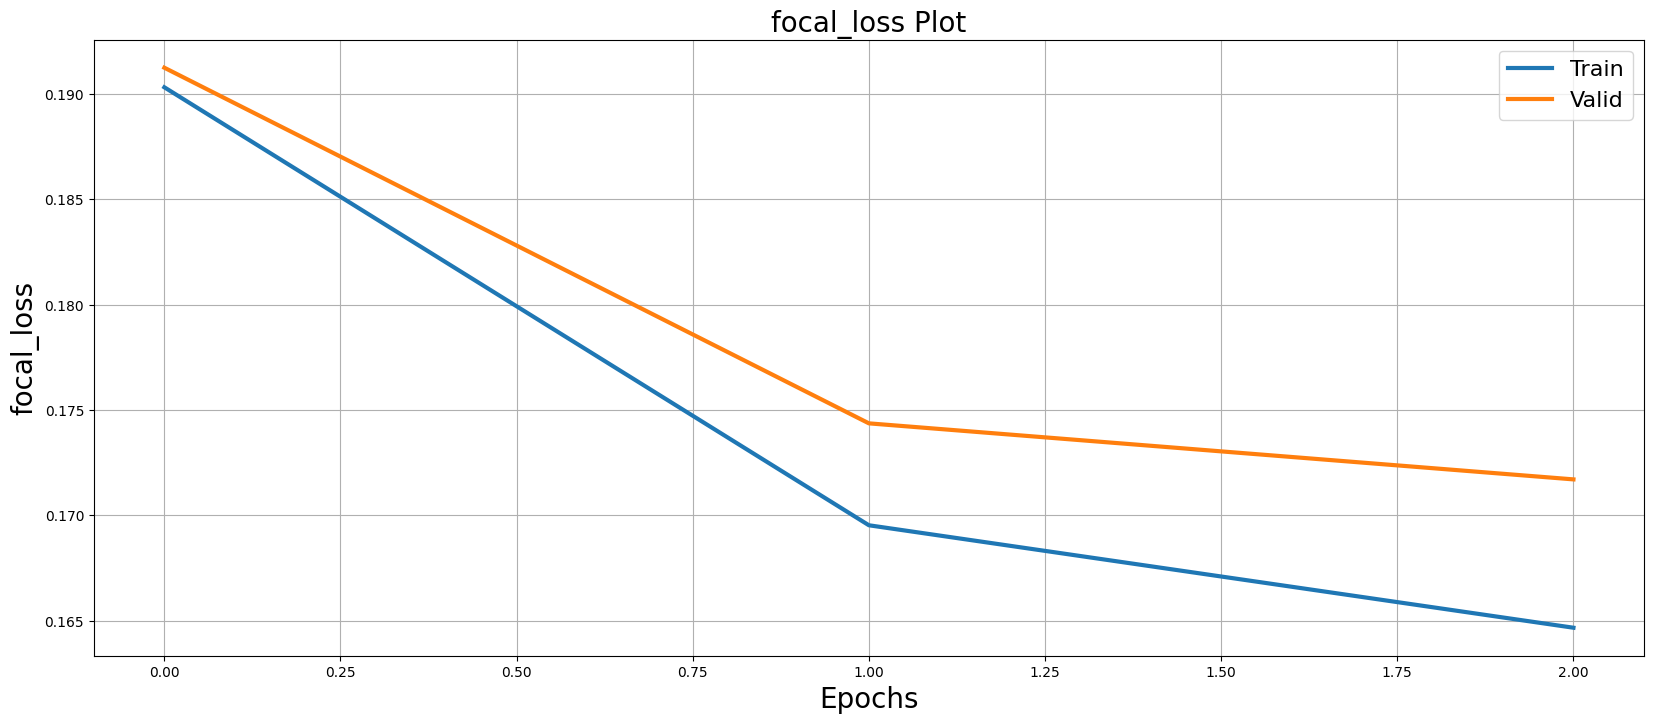

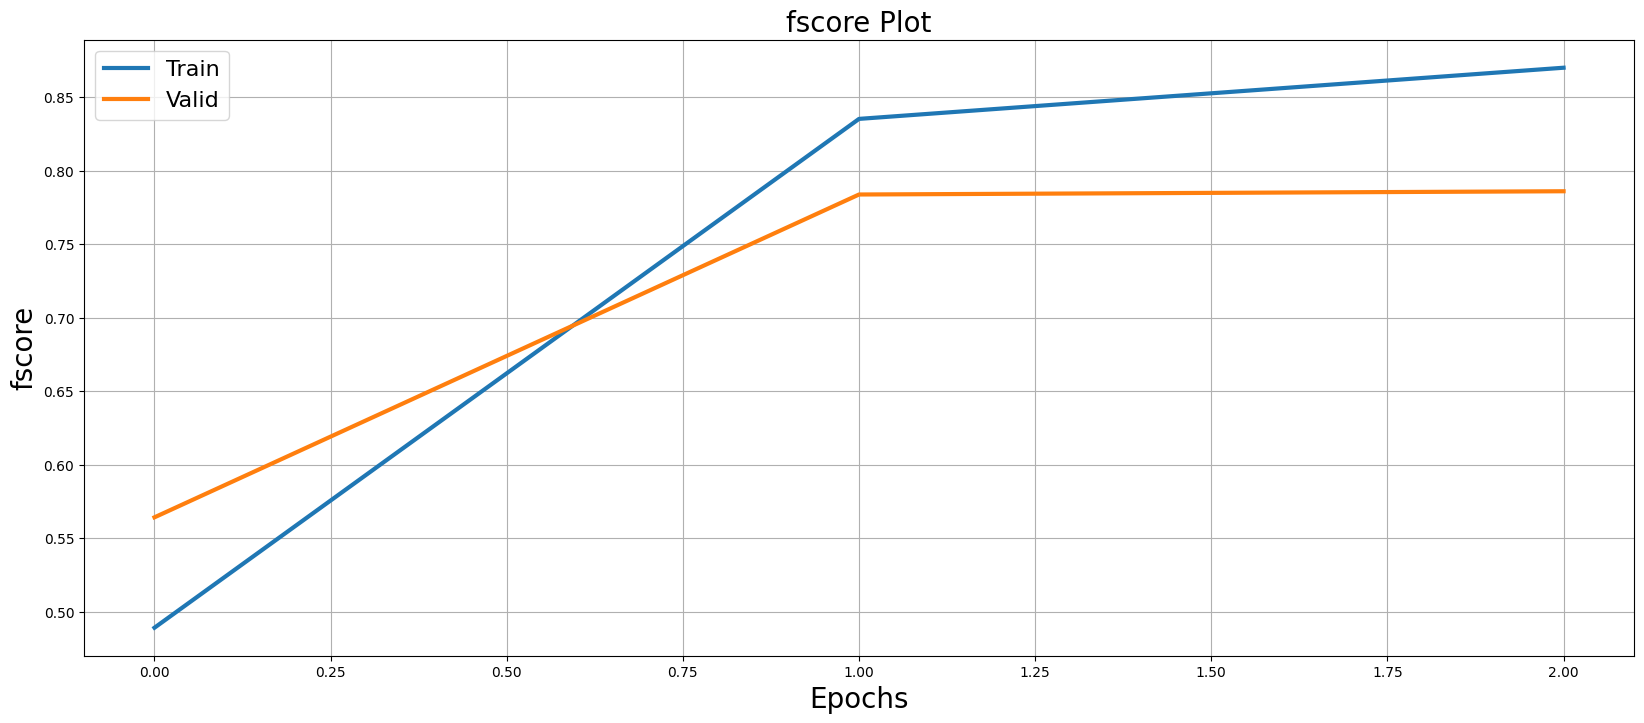

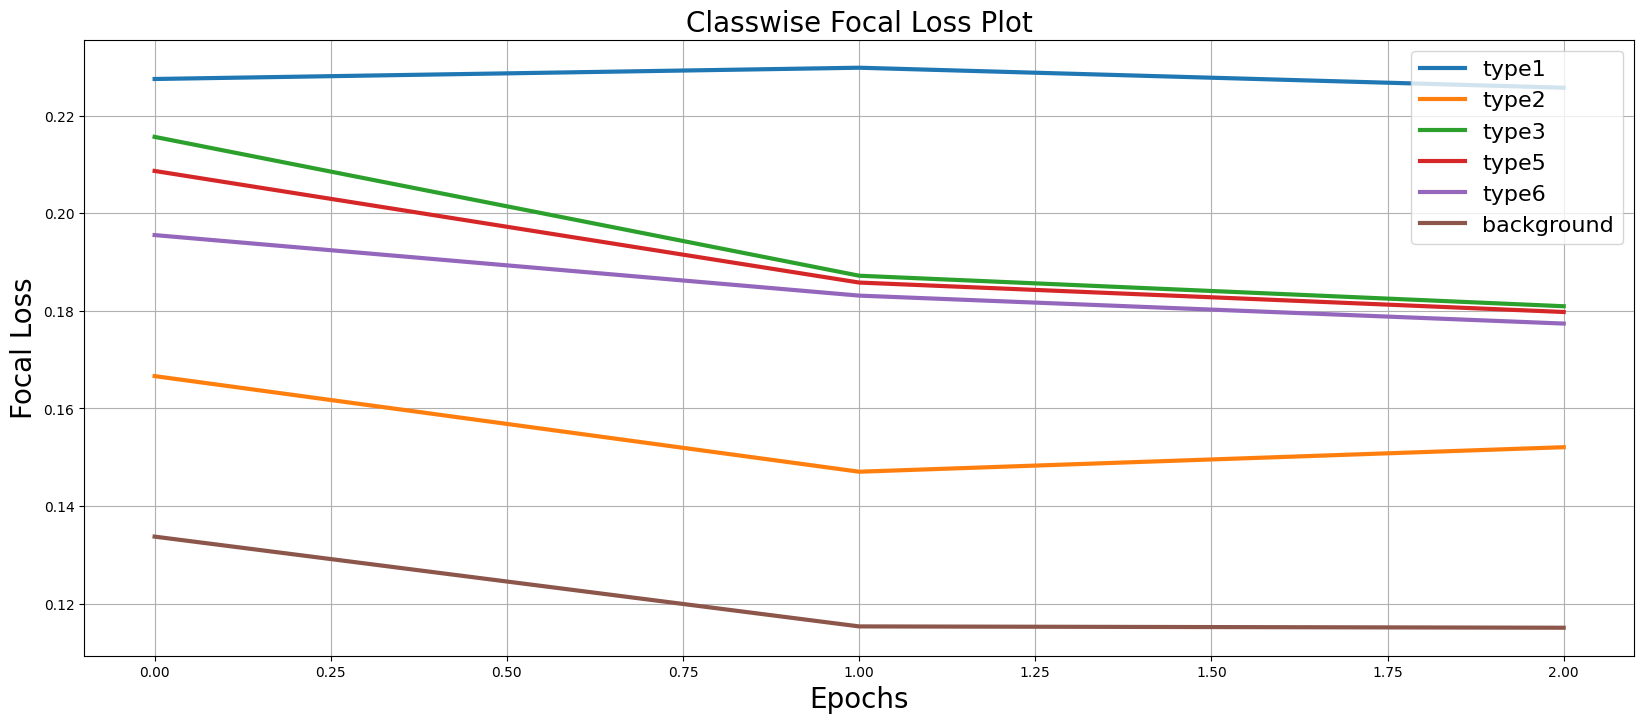

In [14]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.focal_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.focal_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('focal_loss', fontsize=20)
plt.title('focal_loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.fscore.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.fscore.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('fscore', fontsize=20)
plt.title('fscore Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
# plt.savefig('dice_loss_plot.png')
plt.show()

# 클래스별 loss
plt.figure(figsize=(20, 8))
for class_name, losses in classwise_epoch_loss.items():
    plt.plot(range(len(losses)), losses, lw=3, label=class_name)

plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Focal Loss', fontsize=20)
plt.title('Classwise Focal Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('classwise_focal_loss_plot.png')
plt.show()
